In [31]:
tr_path = 'deal_train.csv'  # path to training data
tt_path = 'deal_test.csv'   # path to te|sting data
se_path = 'season.csv'

In [32]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [45]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.xlabel('Training steps')
    plt.ylim(0.0, 1.)
    plt.ylabel('loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


In [34]:
tr_sz = 0
dv_sz = 0
class empDataset(Dataset):

    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode
        global tr_sz
        global dv_sz
        # Read data into numpy arrays
        with open(path, 'r', encoding="Big5") as fp:
            data = list(csv.reader(fp))
            data = np.array([list(map(float,i)) for i in data[1:]]).astype(float)
        self.idx = data[:,2]
        if not target_only:
            feats = list(range(4,46))
        else:
            feats = list(range(4,46))
        if mode == 'test':
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, 3]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 < 7]
#             elif mode == 'valid':
#                 indices = [i for i in range(len(data)) if i % 10 == 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 >= 7]
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.LongTensor(target[indices])
        
        self.dim = self.data.shape[1]
        if mode == 'train':
            tr_sz = len(self.data)
        elif mode == 'dev':
            dv_sz = len(self.data)
        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev', 'valid']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index], self.idx[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [35]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = empDataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [36]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=1.0)
        m.bias.data.fill_(0.01)

class Classifier(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(Classifier, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64,2),
        )
        self.net.apply(init_weights)
        self.criterion = nn.CrossEntropyLoss() 

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)

In [37]:
best_acc = 0.0
def train(tr_set, dv_set, model, config, device, tr_sz, dv_sz):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])
    global best_acc
    epoch = 0
    model_path = './model.ckpt'
    loss_record = {"train":[], "dev":[]}
    while epoch < n_epochs:
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0
        model.train()                           # set model to training mode
        for inputs, labels in tr_set:                     # iterate through the dataloader
            inputs, labels = inputs.to(device), labels.to(device)   # move data to device (cpu/cuda)
            outputs = model(inputs)                     # forward pass (compute output)
#             print(outputs, labels, inputs)
            batch_loss = model.cal_loss(outputs, labels)  # compute loss
            _, train_pred = torch.max(outputs, 1) 
            batch_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            optimizer.zero_grad()               # set gradient to zero
            train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
            train_loss += batch_loss.item()
        loss_record["train"].append(train_loss/len(tr_set))
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in dv_set:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = model.cal_loss(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()
            loss_record["dev"].append(val_loss/len(dv_set))
            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, n_epochs, train_acc/tr_sz, train_loss/len(tr_set), val_acc/dv_sz, val_loss/len(dv_set)
            ))
            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/dv_sz))

        epoch += 1
    print('Finished training after {} epochs'.format(epoch))
    return val_loss, loss_record

In [38]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                 # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 300,                # maximum number of epochs
    'batch_size': 256,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0001,                 # learning rate of SGD
#         'weight_decay':0.005,
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 1000,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [39]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
# va_set = prep_dataloader(tr_path, 'valid', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of Dataset (10075 samples found, each dim = 42)
Finished reading the dev set of Dataset (4317 samples found, each dim = 42)
Finished reading the test set of Dataset (3739 samples found, each dim = 42)


In [40]:
model = Classifier(tr_set.dataset.dim).to(device)  # Construct model and move to device

In [41]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device, tr_sz, dv_sz)

[001/300] Train Acc: 0.854094 Loss: 16703.432511 | Val Acc: 0.946491 loss: 6.246940
saving model with acc 0.946
[002/300] Train Acc: 0.943921 Loss: 0.676904 | Val Acc: 0.946491 loss: 6.910734
[003/300] Train Acc: 0.943921 Loss: 0.662169 | Val Acc: 0.946491 loss: 6.906452
[004/300] Train Acc: 0.943921 Loss: 0.647843 | Val Acc: 0.946491 loss: 6.892586
[005/300] Train Acc: 0.943921 Loss: 0.634134 | Val Acc: 0.946491 loss: 6.879096
[006/300] Train Acc: 0.943921 Loss: 0.621036 | Val Acc: 0.946491 loss: 6.866152
[007/300] Train Acc: 0.943921 Loss: 0.608235 | Val Acc: 0.946491 loss: 6.853705
[008/300] Train Acc: 0.943921 Loss: 0.596021 | Val Acc: 0.946491 loss: 6.841721
[009/300] Train Acc: 0.943921 Loss: 0.584219 | Val Acc: 0.946491 loss: 6.830210
[010/300] Train Acc: 0.943921 Loss: 0.573145 | Val Acc: 0.946491 loss: 6.819109
[011/300] Train Acc: 0.943921 Loss: 0.562190 | Val Acc: 0.946491 loss: 6.808480
[012/300] Train Acc: 0.943921 Loss: 0.552035 | Val Acc: 0.946491 loss: 6.798193
[013/300

[104/300] Train Acc: 0.943921 Loss: 0.261421 | Val Acc: 0.946491 loss: 6.509657
[105/300] Train Acc: 0.943921 Loss: 0.260380 | Val Acc: 0.946491 loss: 6.508922
[106/300] Train Acc: 0.943921 Loss: 0.259973 | Val Acc: 0.946491 loss: 6.508189
[107/300] Train Acc: 0.943921 Loss: 0.259269 | Val Acc: 0.946491 loss: 6.507487
[108/300] Train Acc: 0.943921 Loss: 0.258586 | Val Acc: 0.946491 loss: 6.506787
[109/300] Train Acc: 0.943921 Loss: 0.258846 | Val Acc: 0.946491 loss: 6.506100
[110/300] Train Acc: 0.943921 Loss: 0.256320 | Val Acc: 0.946491 loss: 6.505437
[111/300] Train Acc: 0.943921 Loss: 0.255671 | Val Acc: 0.946491 loss: 6.504774
[112/300] Train Acc: 0.943921 Loss: 0.255657 | Val Acc: 0.946491 loss: 6.504128
[113/300] Train Acc: 0.943921 Loss: 0.254377 | Val Acc: 0.946491 loss: 6.503492
[114/300] Train Acc: 0.943921 Loss: 0.255055 | Val Acc: 0.946491 loss: 6.502873
[115/300] Train Acc: 0.943921 Loss: 0.253505 | Val Acc: 0.946491 loss: 6.502268
[116/300] Train Acc: 0.943921 Loss: 0.25

[207/300] Train Acc: 0.943921 Loss: 0.225912 | Val Acc: 0.946491 loss: 6.474356
[208/300] Train Acc: 0.943921 Loss: 0.226573 | Val Acc: 0.946491 loss: 6.474209
[209/300] Train Acc: 0.943921 Loss: 0.225270 | Val Acc: 0.946491 loss: 6.474075
[210/300] Train Acc: 0.943921 Loss: 0.225898 | Val Acc: 0.946491 loss: 6.473939
[211/300] Train Acc: 0.943921 Loss: 0.225409 | Val Acc: 0.946491 loss: 6.473808
[212/300] Train Acc: 0.943921 Loss: 0.226460 | Val Acc: 0.946491 loss: 6.473674
[213/300] Train Acc: 0.943921 Loss: 0.225160 | Val Acc: 0.946491 loss: 6.473547
[214/300] Train Acc: 0.943921 Loss: 0.225019 | Val Acc: 0.946491 loss: 6.473422
[215/300] Train Acc: 0.943921 Loss: 0.224899 | Val Acc: 0.946491 loss: 6.473294
[216/300] Train Acc: 0.943921 Loss: 0.225580 | Val Acc: 0.946491 loss: 6.473166
[217/300] Train Acc: 0.943921 Loss: 0.225447 | Val Acc: 0.946491 loss: 6.473039
[218/300] Train Acc: 0.943921 Loss: 0.224546 | Val Acc: 0.946491 loss: 6.472924
[219/300] Train Acc: 0.943921 Loss: 0.22

[6.246939529390896, 6.910734323894276, 6.906452308682835, 6.892585919183843, 6.8790960697566765, 6.866151834235472, 6.853705486830543, 6.841721376952003, 6.830209626870997, 6.819108941975762, 6.808480325867148, 6.798192599240472, 6.788381611599641, 6.778882356250987, 6.7697579124394585, 6.761025370920406, 6.752543686067357, 6.7443943584666535, 6.736511957996032, 6.7289360393496125, 6.721618124667336, 6.714608506244772, 6.707820448805304, 6.701290277873769, 6.694971749011208, 6.688885278561536, 6.683008947793176, 6.67733100231956, 6.6718650197281555, 6.666557820404277, 6.661422096631107, 6.656487938235788, 6.651668390806983, 6.647068823085112, 6.642592161893845, 6.638250370236004, 6.634038925170898, 6.629974232000463, 6.626053757527295, 6.622242654071135, 6.618536617826013, 6.614962856559193, 6.611493117669049, 6.6081396166016075, 6.60488319922896, 6.6017089521183685, 6.598641974084518, 6.595650320543962, 6.59274560213089, 6.589934179011514, 6.587224653538535, 6.584579190787147, 6.58201

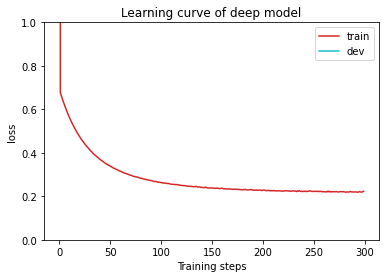

In [47]:
plot_learning_curve(model_loss_record, title='deep model')

In [43]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w', newline='') as fp:
        writer = csv.writer(fp)
        writer.writerow(['PerNo', 'PerStatus'])
        for i, p in preds:
            writer.writerow([i,p])
model.eval() # set the model to evaluation mode
preds = []
with torch.no_grad():
    for inputs, idx in tt_set:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)
        preds.extend([[int(idx[i]), int(pred[i])]for i in range(pred.shape[0])])
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
